#  Basic Bayesian Linear Regression Implementation

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load in Exercise Data

In [4]:
data = 'Data/'
exercise = pd.read_csv(data + 'exercise.csv')
calories = pd.read_csv(data + 'calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head()

,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


## Plot Relationship

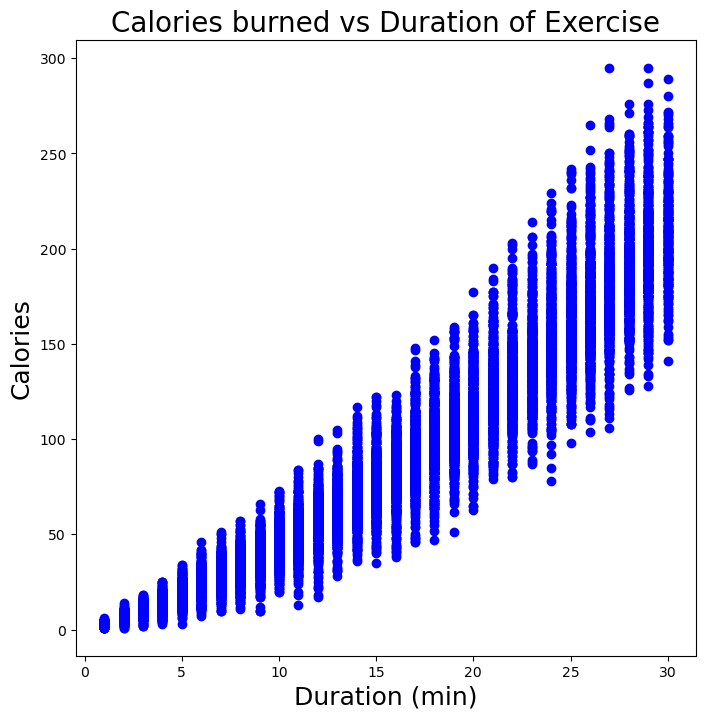

In [5]:
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo');
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [6]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.loc[:, 'Calories']

In [7]:
X.head()

,Intercept,Duration
0,1,29.0
1,1,14.0
2,1,5.0
3,1,13.0
4,1,10.0


In [8]:
y.head()

0    231.0
1     66.0
2     26.0
3     71.0
4     35.0
Name: Calories, dtype: float64

## Implement Ordinary Least Squares Linear Regression by Hand

In [9]:
def linear_regression(X,y):
    _coeffs = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
    return _coeffs

In [10]:
# Run the by hand implementation
by_hand_coefs = linear_regression(X, y)
print('Intercept calculated by hand:', by_hand_coefs[0])
print('Slope calculated by hand: ', by_hand_coefs[1])

Intercept calculated by hand: -21.828102526050806
Slope calculated by hand:  7.16978334958785


C:\Users\Prakalp.Somawanshi\AppData\Local\Temp\ipykernel_16388\4051200231.py:2: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  _coeffs = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)


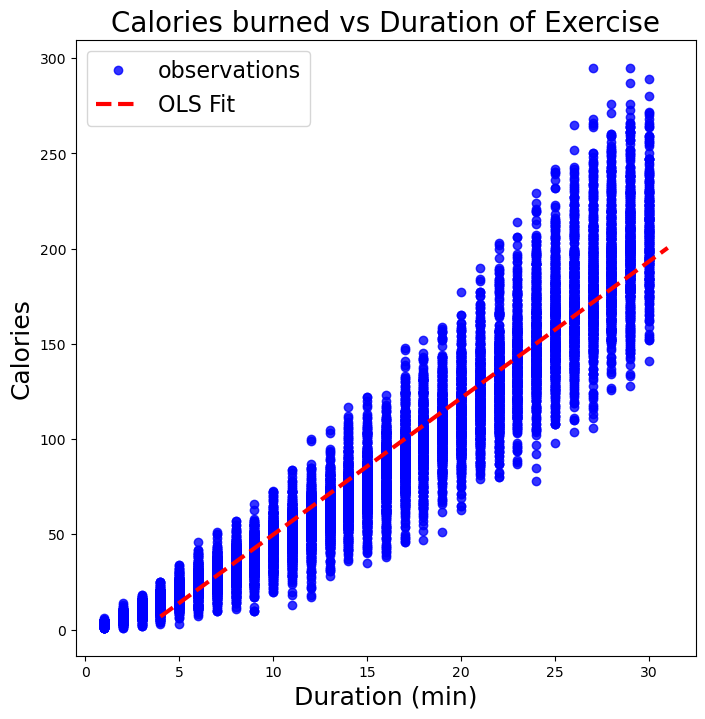

In [11]:
xs = np.linspace(4, 31, 1000)
ys = by_hand_coefs[0] + by_hand_coefs[1] * xs

plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo',label = 'observations', alpha = 0.8);
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.plot(xs, ys, 'r--', label = 'OLS Fit', linewidth = 3)
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [12]:
print('Exercising for 15.5 minutes will burn an estimated {:.2f} calories.'.format(
    by_hand_coefs[0] + by_hand_coefs[1] * 15.5))

Exercising for 15.5 minutes will burn an estimated 89.30 calories.


In [13]:
linear_regression = LinearRegression()
linear_regression.fit(np.array(X.Duration).reshape(-1,1),y)
print('Intercept from library:', linear_regression.intercept_)
print('Slope from library:', linear_regression.coef_[0])

Intercept from library: -21.82810252605087
Slope from library: 7.169783349587856


In [15]:
with pm.Model() as linear_model_500:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[0:499, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values[0:500])
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_500 = pm.sample(1000, step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The acceptance probability does not match the target. It is 0.8861642254306933, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945748716317778, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898409920571271, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915438999561381, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.8874004313566586, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88500974961363, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\Prakalp.Somawanshi\AppData\Local\Temp\ipykernel_16388\4145444418.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(linear_trace, figsize = (12, 12));
C:\Users\Prakalp.Somawanshi\AppData\Local\anaconda3\envs\bayesian_lr\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


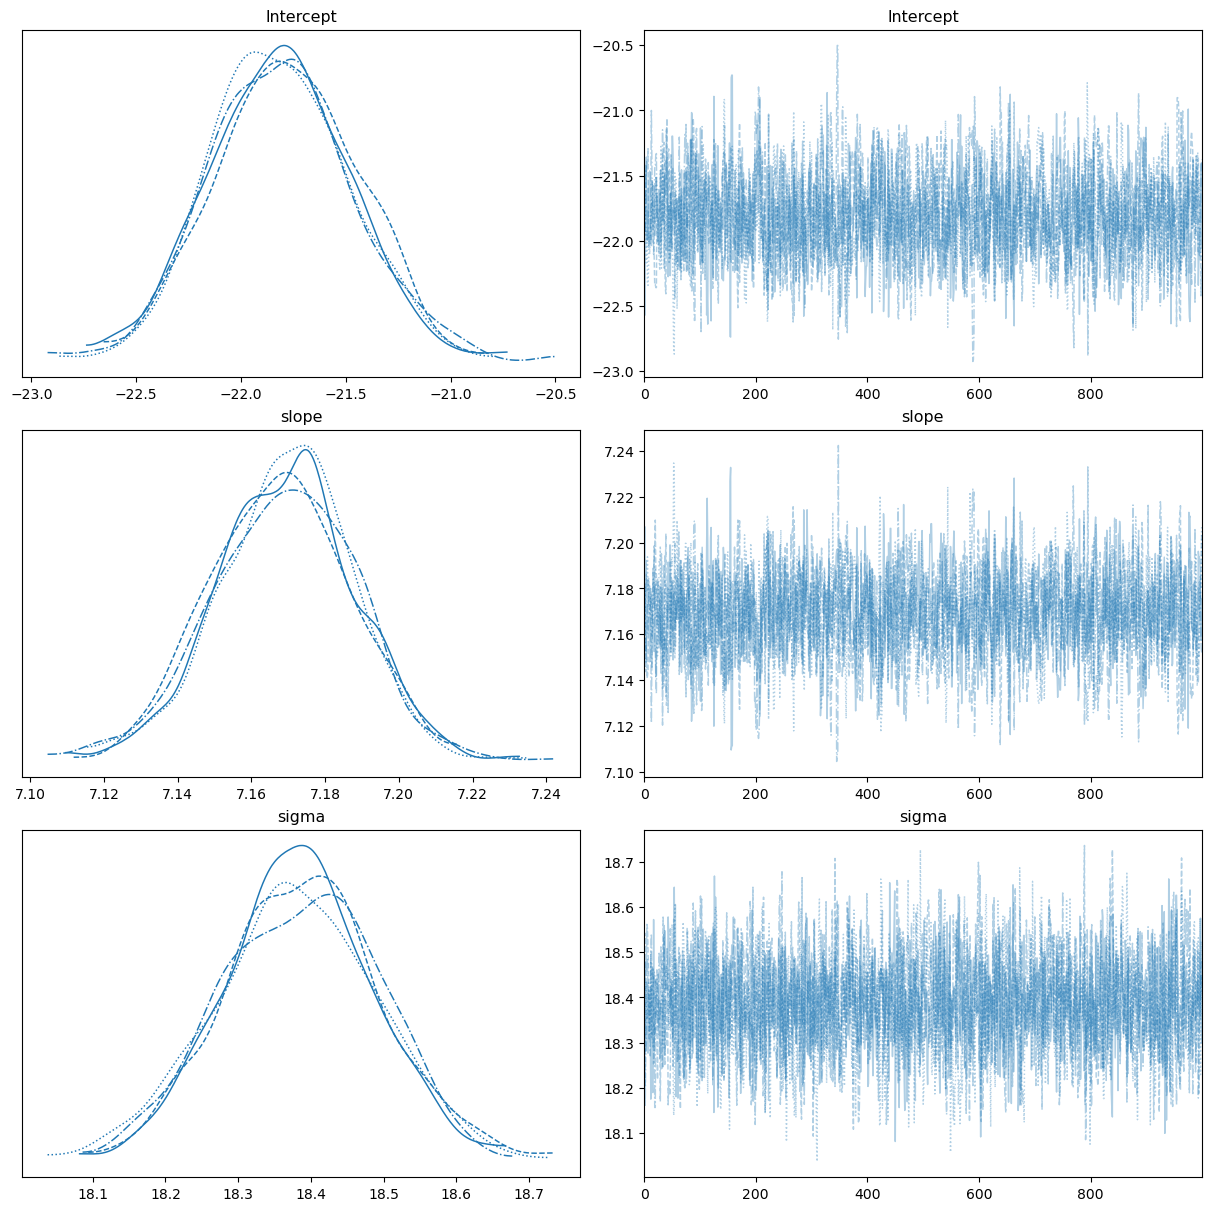

In [17]:
pm.traceplot(linear_trace, figsize = (12, 12));

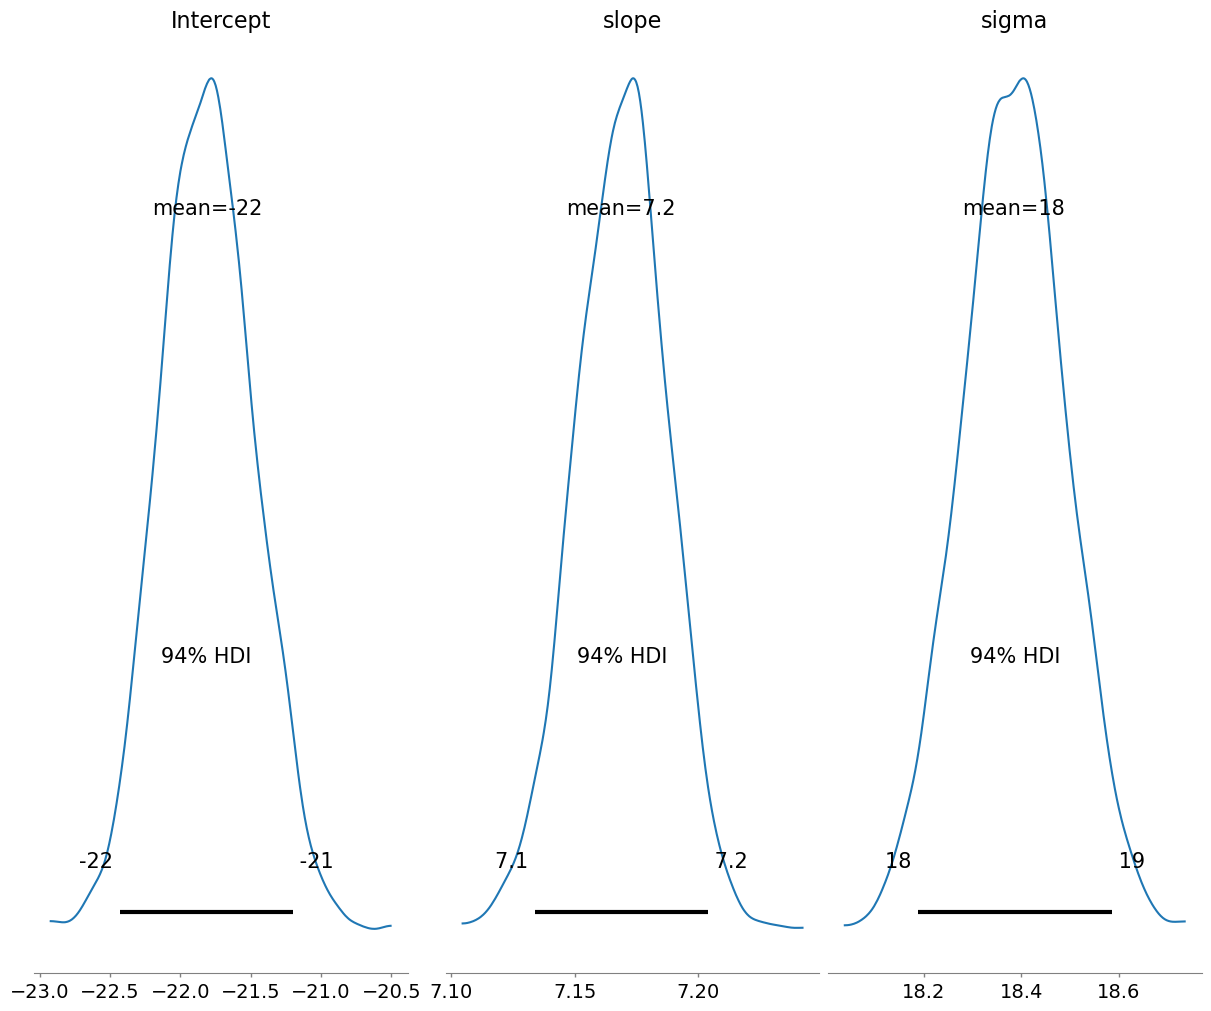

In [19]:
pm.plot_posterior(linear_trace, figsize = (12, 10));
#, text_size = 20);

C:\Users\Prakalp.Somawanshi\AppData\Local\anaconda3\envs\bayesian_lr\lib\site-packages\pymc3\plots\posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


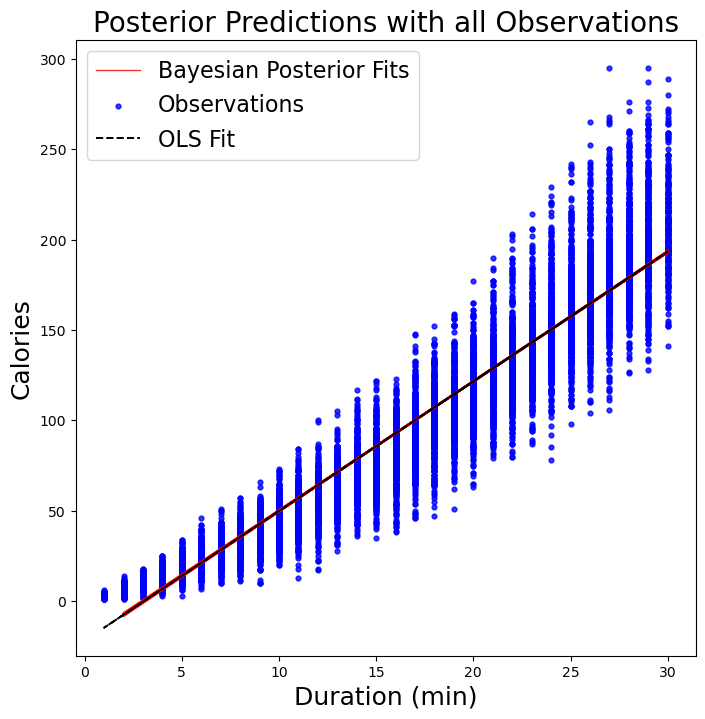

In [20]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

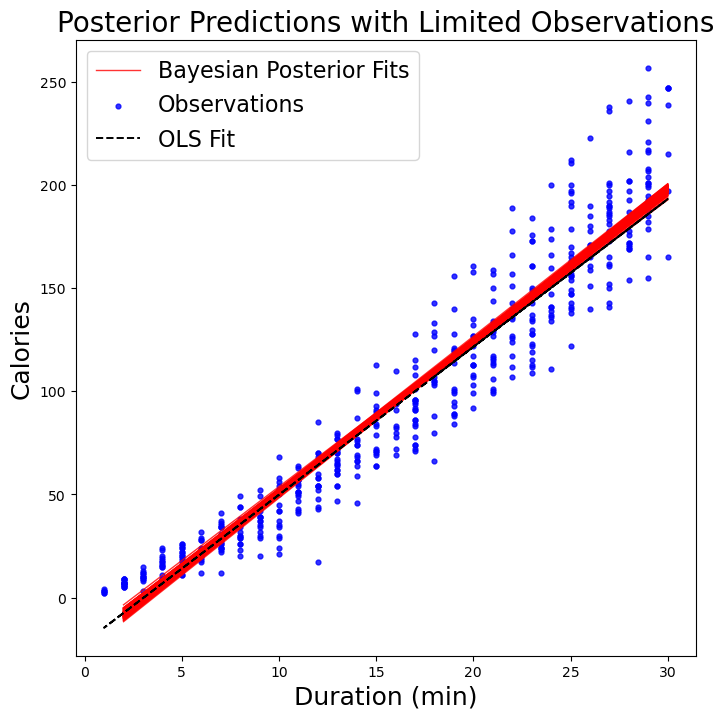

In [21]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'][:500], y.values[:500], s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with Limited Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [22]:
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * 15.5

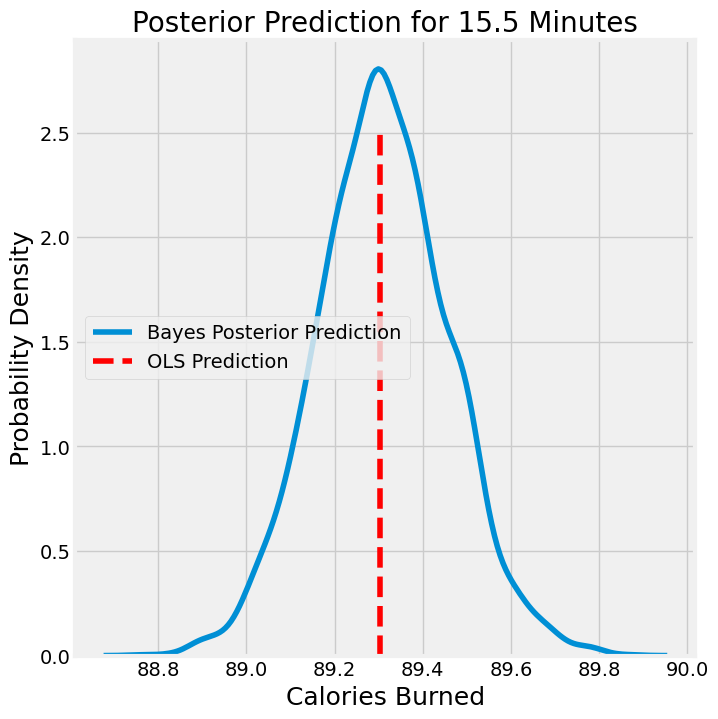

In [23]:
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = by_hand_coefs[0] + by_hand_coefs[1] * 15.5, 
           ymin = 0, ymax = 2.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')
plt.legend();
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for 15.5 Minutes', size = 20);